In [ ]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf
import unicodedata

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Recurrence-based Seq2Seq Neural Machine Translation Without Attention

Model kami hanya menggunakan dua LSTM (satu encoder dan satu decoder) untuk menerjemahkan

Dataset yang akan kita gunakan berasal dari file .srt.

In [ ]:
# Upload the training set.

!wget https://github.com/AkhmadBagusMubarok/Final_Dataset_and_Output_Dataset/blob/main/Final_Output_Jumanji2017/jumjdatbase(2).txt


Saving jumjdatbase(2).txt to jumjdatbase(2) (2).txt


{'jumjdatbase(2).txt': b"\xef\xbb\xbfHei, Nak.<sep>Hey, kiddo.\r\nApa? Aku menemukan sesuatu.<sep>What? I found something.\r\nAnda harus memeriksa ini.<sep>You gotta check this out.\r\nJumanji.<sep>Jumanji.\r\nPapan permainan?<sep>Board game?\r\nSiapa yang memainkan permainan papan?<sep>Who plays board games?\r\nMenangkis.  Menangkis.<sep>Parry. Parry.\r\nMenghindari.  Salah.<sep>Evade. Blam.\r\nPukulan.<sep>Uppercut.\r\nBenturan kepala.  Matilah Kau.<sep>Head slam. You're dead.\r\nMemukul. Memukul. Serangan balik. Benturan kepala.<sep>Strike. Strike. Counterstrike. Head slam.\r\nKa-pow.<sep>Ka-pow.\r\nSiap-siap.  Bertarung.<sep>Get ready. Fight.\r\nSaya mendapatkannya.<sep>I got it.\r\n...Benjamin Franklin,<sep>...Benjamin Franklin,\r\ndan rasa keistimewaan nasional inilah yang<sep>and it was this sense of national exceptionalism\r\nmemicu meluasnya ekspansi ke arah barat.<sep>that fueled the spreading wildfire of westward expansion.\r\nSpencer?  Sayang?<sep>Spencer? Honey?\r\nAah! Bu

In [ ]:
with open('jumjdatbase(2).txt', encoding='utf-8-sig') as file:
  train = [line.rstrip() for line in file]



Setiap entri terdiri dari kalimat subtittle Indonesia diikuti dengan translasi bahasa Inggrisnya, dipisahkan oleh pembatas (sep)

In [ ]:
train[:3]

['Hei, Nak.<sep>Hey, kiddo.',
 'Apa? Aku menemukan sesuatu.<sep>What? I found something.',
 'Anda harus memeriksa ini.<sep>You gotta check this out.']

In [ ]:
len(train)

1802

In [ ]:
SEPARATOR = '<sep>'
train_input, train_target = map(list, zip(*[pair.split(SEPARATOR) for pair in train]))

In [ ]:
print(train_input[:3])
print(train_target[:3])

['Hei, Nak.', 'Apa? Aku menemukan sesuatu.', 'Anda harus memeriksa ini.']
['Hey, kiddo.', 'What? I found something.', 'You gotta check this out.']


Penerapan normalisasi Unicode

In [ ]:
print("\u00E1", "\u0061\u0301")

á á


In [ ]:
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

Fungsi ini akan menampilkan tanda baca sebagai token terpisah dan normalisasi unicode.

In [ ]:
def preprocess_sentence(s):
  s = normalize_unicode(s)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  return s

In [ ]:
train_preprocessed_input = [preprocess_sentence(s) for s in train_input]
train_preprocessed_target = [preprocess_sentence(s) for s in train_target]

Setelah preprocessing, unicode harus dinormalisasi dan harus ada spasi di kedua sisi tanda baca.

In [ ]:
train_preprocessed_input[:3]

['Hei , Nak .', 'Apa ? Aku menemukan sesuatu .', 'Anda harus memeriksa ini .']

Menggunakan Teacher Forcing yang menempatkan tag awal kalimat (sos) dan tag akhir kalimat (eos) masing-masing di awal dan akhir setiap kalimat target.

In [ ]:
def tag_target_sentences(sentences):
  tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
  return list(tagged_sentences)

In [ ]:
train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

In [ ]:
train_tagged_preprocessed_target[:3]

['<sos> Hey , kiddo . <eos>',
 '<sos> What ? I found something . <eos>',
 '<sos> You gotta check this out . <eos>']

Tokenize kalimat input dan target.

Menyertakan token out-of-vocabulary (oov) dalam inisialisasi tokenizer.

Pada waktu inferensi, jika tokenizer menemukan kata yang tidak dilihatnya selama penyesuaian awal pada training data, kata tersebut akan diganti dengan (oov) dan sistem terjemahan harus mengatasinya.

In [ ]:
source_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_preprocessed_input)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<oov>',
 'document_count': 1802,
 'word_counts': '{"hei": 17, ",": 698, "nak": 1, ".": 1811, "apa": 193, "?": 456, "aku": 167, "menemukan": 10, "sesuatu": 13, "anda": 279, "harus": 58, "memeriksa": 2, "ini": 175, "jumanji": 35, "papan": 3, "permainan": 19, "siapa": 21, "yang": 238, "memainkan": 1, "menangkis": 5, "menghindari": 4, "salah": 16, "pukulan": 3, "benturan": 3, "kepala": 6, "matilah": 1, "kau": 24, "memukul": 5, "serangan": 1, "balik": 1, "ka": 2, "pow": 1, "siap": 6, "bertarung": 1, "saya": 390, "mendapatkannya": 7, "benjamin": 1, "franklin": 3, "dan": 136, "rasa": 6, "keistimewaan": 2, "nasional": 2, "inilah": 6, "memicu": 2, "meluasnya": 2, "ekspansi": 5, "ke": 43, "arah": 5, "barat": 5, "spencer": 49, "sayang": 7, "aah": 8, "!": 244, "bu": 2, "kita": 113, "katakan": 13, "tentang": 16, "ketukan": 1, "itu": 222, "terlambat": 2, "bekerja": 2,

In [ ]:
source_vocab_size = len(source_tokenizer.word_index) + 1
print(source_vocab_size)

1627


In [ ]:
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<oov>',
 'document_count': 1802,
 'word_counts': '{"<sos>": 1802, "hey": 33, ",": 795, "kiddo": 1, ".": 1824, "<eos>": 1802, "what": 167, "?": 456, "i": 359, "found": 7, "something": 17, "you": 419, "gotta": 26, "check": 2, "this": 119, "out": 46, "jumanji": 34, "board": 2, "game": 31, "who": 19, "plays": 2, "games": 5, "parry": 5, "evade": 3, "blam": 2, "uppercut": 2, "head": 6, "slam": 3, "you\'re": 58, "dead": 2, "strike": 2, "counterstrike": 1, "ka": 2, "pow": 1, "get": 69, "ready": 4, "fight": 2, "got": 33, "it": 159, "benjamin": 1, "franklin": 3, "and": 139, "was": 38, "sense": 2, "of": 109, "national": 2, "exceptionalism": 2, "that": 132, "fueled": 2, "the": 287, "spreading": 3, "wildfire": 3, "westward": 5, "expansion": 5, "spencer": 49, "honey": 1, "aah": 8, "!": 244, "mom": 2, "did": 28, "we": 108, "say": 14, "about": 33, "knocking": 1, "i\'m":

In [ ]:
target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

1524


Vectorize kalimat input dan target.

In [ ]:
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_preprocessed_input)

In [ ]:
print(train_encoder_inputs[:3])
print(source_tokenizer.sequences_to_texts(train_encoder_inputs[:3]))

[[89, 3, 806, 2], [11, 4, 13, 143, 112, 2], [7, 27, 518, 12, 2]]
['hei , nak .', 'apa ? aku menemukan sesuatu .', 'anda harus memeriksa ini .']


Fungsi di bawah mengambil kumpulan kalimat, memvektorisasi, lalu menjadikan masing-masing dua salinan. Yang pertama akan menyertakan setiap token kecuali yang terakhir. Yang kedua akan menyertakan setiap token kecuali yang pertama.

In [ ]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs]
  decoder_targets = [s[1:] for s in seqs]

  return decoder_inputs, decoder_targets

In [ ]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target,
                                                                              target_tokenizer)

In [ ]:
print(train_decoder_inputs[0], train_decoder_targets[0])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]),
      target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[3, 64, 5, 776, 2] [64, 5, 776, 2, 4]
['<sos> hey , kiddo .'] ['hey , kiddo . <eos>']


Mengisi semua urutan dengan panjang yang seragam.

In [ ]:
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

18

In [ ]:
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

21

In [ ]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [ ]:
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[ 89   3 806   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  3  64   5 776   2   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[ 64   5 776   2   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


In [ ]:
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

['<sos> hey , kiddo . <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov> <oov>']

Menyiapkan dataset validasi.

In [ ]:
# Upload validation set pairs.

!wget https://github.com/AkhmadBagusMubarok/Final_Dataset_and_Output_Dataset/blob/main/Final_Output_Jumanji2017/jumjdatbase(2).txt

Saving jumjdatbase(2).txt to jumjdatbase(2) (3).txt


{'jumjdatbase(2).txt': b"\xef\xbb\xbfHei, Nak.<sep>Hey, kiddo.\r\nApa? Aku menemukan sesuatu.<sep>What? I found something.\r\nAnda harus memeriksa ini.<sep>You gotta check this out.\r\nJumanji.<sep>Jumanji.\r\nPapan permainan?<sep>Board game?\r\nSiapa yang memainkan permainan papan?<sep>Who plays board games?\r\nMenangkis.  Menangkis.<sep>Parry. Parry.\r\nMenghindari.  Salah.<sep>Evade. Blam.\r\nPukulan.<sep>Uppercut.\r\nBenturan kepala.  Matilah Kau.<sep>Head slam. You're dead.\r\nMemukul. Memukul. Serangan balik. Benturan kepala.<sep>Strike. Strike. Counterstrike. Head slam.\r\nKa-pow.<sep>Ka-pow.\r\nSiap-siap.  Bertarung.<sep>Get ready. Fight.\r\nSaya mendapatkannya.<sep>I got it.\r\n...Benjamin Franklin,<sep>...Benjamin Franklin,\r\ndan rasa keistimewaan nasional inilah yang<sep>and it was this sense of national exceptionalism\r\nmemicu meluasnya ekspansi ke arah barat.<sep>that fueled the spreading wildfire of westward expansion.\r\nSpencer?  Sayang?<sep>Spencer? Honey?\r\nAah! Bu

In [ ]:
with open('jumjdatbase(2).txt', encoding='utf-8-sig') as file:
  val = [line.rstrip() for line in file]



In [ ]:
def process_dataset(dataset):
  input, output = map(list, zip(*[pair.split(SEPARATOR) for pair in dataset]))

  preprocessed_input = [preprocess_sentence(s) for s in input]
  preprocessed_output = [preprocess_sentence(s) for s in output]

  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [ ]:
# validation dataset
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val)

Membangun model.

In [ ]:
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 32
epochs = 30

Encoder menerima kalimat sumber (Bahasa Indonesia) dan menghasilkan initial state input untuk dekoder. Decoder menerima kalimat input decoder (Bahasa Inggris) untuk teacher forcing.

In [ ]:
encoder_inputs = layers.Input(shape=[None], name='encoder_inputs')

encoder_embeddings = layers.Embedding(source_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='encoder_embeddings')

encoder_embedding_output = encoder_embeddings(encoder_inputs)

encoder_lstm = layers.LSTM(hidden_dim,
                           return_state=True,
                           dropout=default_dropout,
                           name='encoder_lstm')

encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)

encoder_states = (state_h, state_c)

In [ ]:
decoder_inputs = layers.Input(shape=[None], name='decoder_inputs')

decoder_embeddings = layers.Embedding(target_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='decoder_embeddings')

decoder_embedding_output = decoder_embeddings(decoder_inputs)

decoder_lstm = layers.LSTM(hidden_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=default_dropout,
                           name='decoder_lstm')

decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

y_proba = decoder_dense(decoder_outputs)

Membuat model dan membangunnya memiliki dua input dan satu output. Dengan menggunakan performance metric, BLEU.

In [ ]:
model = tf.keras.Model([encoder_inputs, decoder_inputs], y_proba, name='hun_eng_seq2seq_nmt_no_attention')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics='sparse_categorical_accuracy')
model.summary()

Model: "hun_eng_seq2seq_nmt_no_attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embeddings (Embedding)  (None, None, 128)   208256      ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embeddings (Embedding)  (None, None, 128)   195072      ['decoder_inputs[0][0]']         
                                                                   

Visualisasi model.

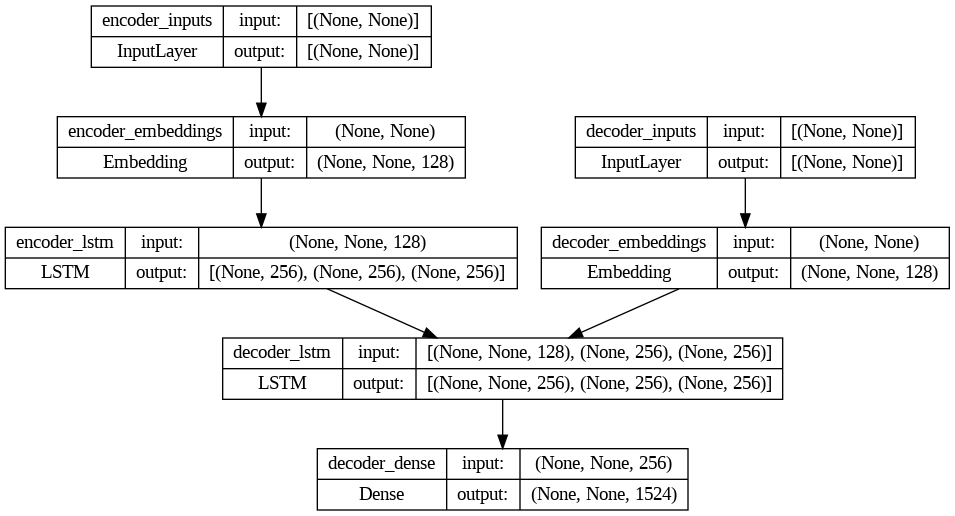

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='hun_eng_seq2seq_nmt_no_attention.png', show_shapes=True, show_layer_names=True)

Matrix dimensions

In [ ]:
print('encoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len)))
print()
print('encoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len, embedding_dim)))
print()
print('encoder_lstm layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len, embedding_dim), [(batch_size, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print()
print('decoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len)))
print()
print('decoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len, embedding_dim)))
print()
print('decoder_lstm layer\n input dimension {}\n output dimension: {}'.format([(batch_size, max_decoding_len, embedding_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)], [(batch_size, max_decoding_len, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print('decoder_dense layer(softmax)\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len, hidden_dim), (batch_size, max_decoding_len, target_vocab_size)))

encoder_inputs layer
 input dimension (32, 18)
 output dimension: (32, 18)

encoder_embeddings layer
 input dimension (32, 18)
 output dimension: (32, 18, 128)

encoder_lstm layer
 input dimension (32, 18, 128)
 output dimension: [(32, 256), (32, 256), (32, 256)]


decoder_inputs layer
 input dimension (32, 21)
 output dimension: (32, 21)

decoder_embeddings layer
 input dimension (32, 21)
 output dimension: (32, 21, 128)

decoder_lstm layer
 input dimension [(32, 21, 128), (32, 256), (32, 256)]
 output dimension: [(32, 21, 256), (32, 256), (32, 256)]

decoder_dense layer(softmax)
 input dimension (32, 21, 256)
 output dimension: (32, 21, 1524)


Model checkpoints

In [ ]:
filepath= r"E:\@capstone\datbase\train, test, val"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

Early stopping & Fit method

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1.5)
history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
                      callbacks=[cp_callback, es_callback])

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 1.4705 - sparse_categorical_accuracy: 0.6712
Epoch 1: saving model to E:\@capstone\datbase\train, test, val
57/57 [==============================] - 21s 366ms/step - loss: 1.4705 - sparse_categorical_accuracy: 0.6712 - val_loss: 1.3176 - val_sparse_categorical_accuracy: 0.7095
Epoch 2/30
57/57 [==============================] - ETA: 0s - loss: 1.4036 - sparse_categorical_accuracy: 0.6855
Epoch 2: saving model to E:\@capstone\datbase\train, test, val
57/57 [==============================] - 19s 339ms/step - loss: 1.4036 - sparse_categorical_accuracy: 0.6855 - val_loss: 1.2585 - val_sparse_categorical_accuracy: 0.7272
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 1.3473 - sparse_categorical_accuracy: 0.7016
Epoch 3: saving model to E:\@capstone\datbase\train, test, val
57/57 [==============================] - 20s 351ms/step - loss: 1.3473 - sparse_categorical_accuracy: 0.7016 - val_loss: 1.1889 - va

Menyimpan model dan Tokenizer.

In [ ]:
import zipfile

model.save('jmjsubs_NMT_no_attention')

!zip -r ./jmjsubs_NMT_no_attention.zip ./jmjsubs_NMT_no_attention
files.download("./jmjsubs_NMT_no_attention.zip")

source_tokenizer_json = source_tokenizer.to_json()
with io.open('source_tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(source_tokenizer_json, ensure_ascii=False))

target_tokenizer_json = target_tokenizer.to_json()
with io.open('target_tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(target_tokenizer_json, ensure_ascii=False))

  adding: jmjsubs_NMT_no_attention/ (stored 0%)
  adding: jmjsubs_NMT_no_attention/assets/ (stored 0%)
  adding: jmjsubs_NMT_no_attention/fingerprint.pb (stored 0%)
  adding: jmjsubs_NMT_no_attention/keras_metadata.pb (deflated 91%)
  adding: jmjsubs_NMT_no_attention/variables/ (stored 0%)
  adding: jmjsubs_NMT_no_attention/variables/variables.index (deflated 63%)
  adding: jmjsubs_NMT_no_attention/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: jmjsubs_NMT_no_attention/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mengambil model yang disimpan dan tokenizer yang disimpan dan mencobanya pada test data set.

In [ ]:
# Retrieve the tokenizers.

!wget https://github.com/RanggaAndaRahman123/Tokenizer-Model-Deployed-Model-dan-Notebook/blob/main/Tokenizer%2C%20Model%2C%20Deployed%20Model%2C%20dan%20Notebook/Jumanji(2017)/tokenizer_jmjsubs_NMT_no_attention.zip

Saving tokenizer_jmjsubs_NMT_no_attention.zip to tokenizer_jmjsubs_NMT_no_attention.zip


{'tokenizer_jmjsubs_NMT_no_attention.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00\x17\xb6\xceV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00#\x00\x00\x00tokenizer_jmjsubs_NMT_no_attention/PK\x03\x04\x14\x00\x00\x00\x08\x00\xf9\xb5\xceV* \x83\xfb\xad\x92\x00\x00~\xb4\x02\x008\x00\x00\x00tokenizer_jmjsubs_NMT_no_attention/source_tokenizer.jsont\\\xd9v\xec\xb8n\xfd\x95Ng\xe8\x0c7I\xdbn\x9f\xa13\xdc|D\xde\xe2\xa4C\x95h\x89%\x89\xd2\xe2p\xbc\xeat\x92o\x0f q\x106u\xdf\\4%\x92 \x08ll\x80\xfa\xf1\xf7\xb7\x1fo\xb3\xf2\xfe7\xab\x16\xfd\xf6\xe3\xaf?\xbc\xfd\xf8\xef\xeb\xa4\xad\xf9\xae\xdd\xdb\x8f\x7f\xa0\x9f\xb7\xd5\xbe\x9b\x81\xffE}m\\~\xfbX]\xef\xf9\xb7\x8d\xf3\xcc=\xde\xcd\x1c\xb4\xf3\xc7\xd3ooo?\xfe\xf9_\xfc\xe5_\xfd\xf5\xdf\xfc\xed\xdf\xfd\xfd?\xfe\xfaO\xff\xf2o\xffAMo\xff\xf9_\xbf\xfd\xf7\xef\xff\xf3\xbf\xff\xf7\xf6\x16\xde\xde\xec\xf1\xe6y\xfd\xe0A~\xfd!\xb8\xa8\xb9\xc1o\xb3\t\xc7k~H\x83\x8f\xca\xfd6\xeboz\xe6\xe6w5\xfb\xbd\xe3\xba~\xfb-\xf04\x8f\xce\xffL\xbf\xff\xf5x\xa0_oq\xd16\xfcv[\xa3\x

In [ ]:
!unzip -o tokenizer_jmjsubs_NMT_no_attention.zip

Archive:  tokenizer_jmjsubs_NMT_no_attention.zip
   creating: tokenizer_jmjsubs_NMT_no_attention/
  inflating: tokenizer_jmjsubs_NMT_no_attention/source_tokenizer.json  
  inflating: tokenizer_jmjsubs_NMT_no_attention/target_tokenizer.json  


Memuat tokenizer dengan metode tokenizer_from_json.

In [ ]:
with open('source_tokenizer.json') as f:
    data = json.load(f)
    source_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open('target_tokenizer.json') as f:
    data = json.load(f)
    target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [ ]:
# Retrieve the model.

!wget https://github.com/RanggaAndaRahman123/Tokenizer-Model-Deployed-Model-dan-Notebook/blob/main/Tokenizer%2C%20Model%2C%20Deployed%20Model%2C%20dan%20Notebook/Jumanji(2017)/jmjsubs_NMT_no_attention.zip


Saving jmjsubs_NMT_no_attention.zip to jmjsubs_NMT_no_attention (1).zip


In [ ]:
!unzip -o jmjsubs_NMT_no_attention.zip

Archive:  jmjsubs_NMT_no_attention.zip
 extracting: jmjsubs_NMT_no_attention/fingerprint.pb  
  inflating: jmjsubs_NMT_no_attention/keras_metadata.pb  
  inflating: jmjsubs_NMT_no_attention/variables/variables.index  
  inflating: jmjsubs_NMT_no_attention/variables/variables.data-00000-of-00001  
  inflating: jmjsubs_NMT_no_attention/saved_model.pb  


In [ ]:
# Load the model.
model = tf.keras.models.load_model('jmjsubs_NMT_no_attention')

In [ ]:
# Retrieve the test dataset.

!wget https://github.com/AkhmadBagusMubarok/Final_Dataset_and_Output_Dataset/blob/main/Final_Output_Jumanji2017/jumjdatbase(2).txt

Saving jumjdatbase(2).txt to jumjdatbase(2) (4).txt


{'jumjdatbase(2).txt': b"\xef\xbb\xbfHei, Nak.<sep>Hey, kiddo.\r\nApa? Aku menemukan sesuatu.<sep>What? I found something.\r\nAnda harus memeriksa ini.<sep>You gotta check this out.\r\nJumanji.<sep>Jumanji.\r\nPapan permainan?<sep>Board game?\r\nSiapa yang memainkan permainan papan?<sep>Who plays board games?\r\nMenangkis.  Menangkis.<sep>Parry. Parry.\r\nMenghindari.  Salah.<sep>Evade. Blam.\r\nPukulan.<sep>Uppercut.\r\nBenturan kepala.  Matilah Kau.<sep>Head slam. You're dead.\r\nMemukul. Memukul. Serangan balik. Benturan kepala.<sep>Strike. Strike. Counterstrike. Head slam.\r\nKa-pow.<sep>Ka-pow.\r\nSiap-siap.  Bertarung.<sep>Get ready. Fight.\r\nSaya mendapatkannya.<sep>I got it.\r\n...Benjamin Franklin,<sep>...Benjamin Franklin,\r\ndan rasa keistimewaan nasional inilah yang<sep>and it was this sense of national exceptionalism\r\nmemicu meluasnya ekspansi ke arah barat.<sep>that fueled the spreading wildfire of westward expansion.\r\nSpencer?  Sayang?<sep>Spencer? Honey?\r\nAah! Bu

In [ ]:
with open('jumjdatbase(2).txt', encoding='utf-8-sig') as file:
  test = [line.rstrip() for line in file]

In [ ]:
test[:3]

['Hei, Nak.<sep>Hey, kiddo.',
 'Apa? Aku menemukan sesuatu.<sep>What? I found something.',
 'Anda harus memeriksa ini.<sep>You gotta check this out.']

In [ ]:
# test dataset
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(test)

In [ ]:
model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

57/57 [==============================] - 8s 89ms/step - loss: 0.2244 - sparse_categorical_accuracy: 0.9810


[0.2243853211402893, 0.9810181260108948]

Training model untuk kasus inference, dengan membuat stand-alone model encoder dan decoder terpisah.

In [ ]:
[layer.name for layer in model.layers]

['encoder_inputs',
 'decoder_inputs',
 'encoder_embeddings',
 'decoder_embeddings',
 'encoder_lstm',
 'decoder_lstm',
 'decoder_dense']

Membuat stand-alone encoder.

In [ ]:
encoder_inputs = model.get_layer('encoder_inputs').input

encoder_embedding_layer = model.get_layer('encoder_embeddings')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('encoder_lstm')

_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)

encoder_states = [encoder_state_h, encoder_state_c]

encoder_model_no_attention = tf.keras.Model(encoder_inputs, encoder_states)

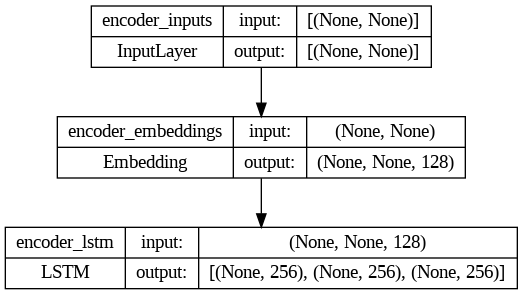

In [ ]:
plot_model(encoder_model_no_attention, to_file='encoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

Membuat stand-alone decoder, dengan dua input tambahan ke dekoder yaitu LSTM hidden state (decoder_input_state_h) dan cell state (decoder_input_state_c).

Stand-alone decoder sekarang mengambil sebagai input: Token (sos) / output dari timestep sebelumnya. Hidden state dan cell state.

Menghasilkan distribusi probabilitas untuk output saat ini, dan hidden state dan cell state baru.

In [ ]:
decoder_inputs = model.get_layer('decoder_inputs').input

decoder_embedding_layer = model.get_layer('decoder_embeddings')
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_input_state_h = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_h')
decoder_input_state_c = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_c')
decoder_input_states = [decoder_input_state_h, decoder_input_state_c]

decoder_lstm = model.get_layer('decoder_lstm')

decoder_sequence_outputs, decoder_output_state_h, decoder_output_state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_input_states
)

decoder_output_states = [decoder_output_state_h, decoder_output_state_c]

decoder_dense = model.get_layer('decoder_dense')
y_proba = decoder_dense(decoder_sequence_outputs)

decoder_model_no_attention = tf.keras.Model(
    [decoder_inputs] + decoder_input_states,
    [y_proba] + decoder_output_states
)

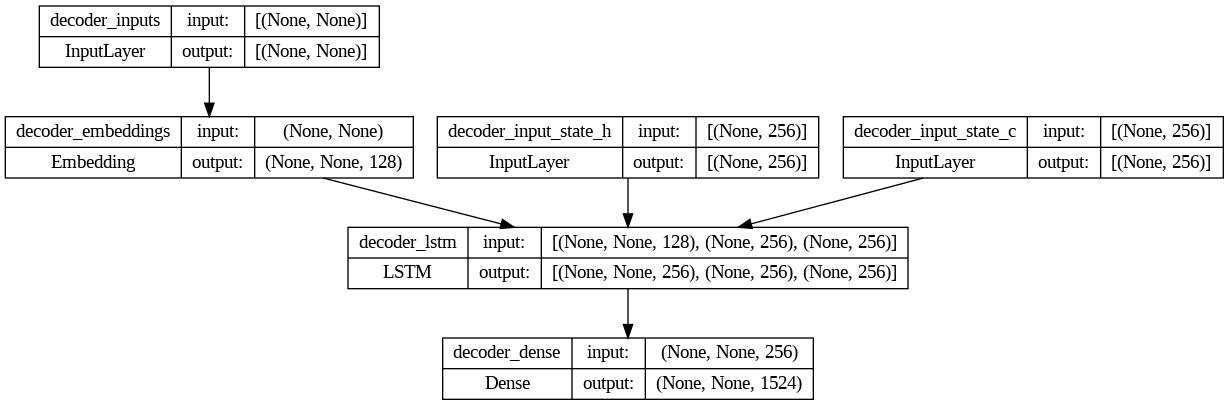

In [ ]:
plot_model(decoder_model_no_attention, to_file='decoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

Metode menerjemahkan kalimat dari bahasa source ke bahasa target. Kata yang dihasilkan output dekoder dan hidden state dan cell state nya kemudian diberikan lagi ke dekoder hingga token (eos) dihasilkan.

In [ ]:
def translate_without_attention(sentence: str,
                                source_tokenizer, encoder,
                                target_tokenizer, decoder,
                                max_translated_len = 30):

  input_seq = source_tokenizer.texts_to_sequences([sentence])

  tokenized_sentence = source_tokenizer.sequences_to_texts(input_seq)

  states = encoder.predict(input_seq)

  current_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < max_translated_len:

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_tokenizer.word_index[current_word]

    target_y_proba, h, c = decoder.predict([target_seq] + states)
    target_token_index = np.argmax(target_y_proba[0, -1, :])
    current_word = target_tokenizer.index_word[target_token_index]

    if (current_word == '<eos>'):
      break

    decoded_sentence.append(current_word)
    states = [h, c]

  return tokenized_sentence[0], ' '.join(decoded_sentence)

Pengujian dengan mengambil sampel kalimat-kalimat dari test dataset.

In [ ]:
random.seed(1)
sentences = random.sample(test, 1802)
sentences

['Oh...<sep>Oh...',
 "Anda seperti, Terserah. Saat mereka mencoba berbicara dengan Anda,<sep>You're like, Whatever. When they try to talk to you,",
 'Sampai jumpa lagi, Bravestone.<sep>See you later, Bravestone.',
 'Kalian.<sep>You guys.',
 'Ayo.  Hai!<sep>Come on. Hey!',
 'Ini sekolah.<sep>This is school.',
 "Ini benar-benar hal utama yang saya lakukan.<sep>It's literally the main thing that I do.",
 "Aku akan menjadi...<sep>I'll be...",
 'Game ini menyebalkan.<sep>This game sucks.',
 "Saya seorang kutu buku.<sep>I'm a nerd.",
 'Dan kemudian Spencer akan meraih dan meraih<sep>And then Spencer will reach in and grab',
 'Menangkis.  Menangkis.  Menghindari.  Memblokir.<sep>Parry. Parry. Evade. Block.',
 'pelajaran menendang pantat.<sep>lessons in kicking ass.',
 "Inilah mengapa kita tidak berteman lagi?<sep>This is why we're not friends anymore?",
 'Bisakah saya berbicara dengan Anda sebentar?<sep>Can I speak with you for a minute?',
 'Dr. Bravestone, saya menyurati Anda<sep>Dr. Bravest

In [ ]:
def translate_sentences(sentences, translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for s in sentences:
    source, target = s.split(SEPARATOR)
    source = preprocess_sentence(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

Memuat hasil ke dalam Pandas DataFrame.

In [ ]:
translations_no_attention = pd.DataFrame(translate_sentences(sentences, translate_without_attention,
                                                             source_tokenizer, encoder_model_no_attention,
                                                             target_tokenizer, decoder_model_no_attention))
translations_no_attention

Output streaming akan dipotong hingga 5000 baris terakhir.
1/1 [==============================] - 0s 46ms/step


,Tokenized Original,Reference,Translation
0,oh . . .,Oh...,oh . . .
1,"anda seperti , terserah . saat mereka mencoba ...","You're like, Whatever. When they try to talk t...","you're like , whatever . when , i don't have it ,"
2,"sampai jumpa lagi , bravestone .","See you later, Bravestone.","see you later , bravestone ."
3,kalian .,You guys.,you guys .
4,ayo . hai !,Come on. Hey!,come on . hey !
...,...,...,...
1797,"yap , itu spencer .","Yep, that's Spencer.","yep , that's spencer ."
1798,kami mengandalkan kalian berempat untuk mengan...,We're counting on the four of you to lift the ...,we're counting on the four of you to lift the ...
1799,betania ?,Bethany?,bethany ?
1800,turun dari punggungku ! apakah kamu baik baik ...,Get off of my back! Are you okay?,get off of my back ! are you okay ?


In [ ]:
translations_no_attention.to_excel('translations_no_attention.xlsx', index=False)

In [ ]:
import pandas as pd
from IPython.display import FileLin

# Membuat tautan unduhan
FileLink('translations_no_attention.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deploy Model ke TensorFlow Lite

In [ ]:
!wget https://github.com/RanggaAndaRahman123/Tokenizer-Model-Deployed-Model-dan-Notebook/blob/main/Tokenizer%2C%20Model%2C%20Deployed%20Model%2C%20dan%20Notebook/Jumanji(2017)/jmjsubs_NMT_no_attention.zip

Saving jmjsubs_NMT_no_attention.zip to jmjsubs_NMT_no_attention.zip


In [ ]:
!unzip -o jmjsubs_NMT_no_attention.zip


Archive:  jmjsubs_NMT_no_attention.zip
   creating: jmjsubs_NMT_no_attention/
   creating: jmjsubs_NMT_no_attention/assets/
 extracting: jmjsubs_NMT_no_attention/fingerprint.pb  
  inflating: jmjsubs_NMT_no_attention/keras_metadata.pb  
   creating: jmjsubs_NMT_no_attention/variables/
  inflating: jmjsubs_NMT_no_attention/variables/variables.index  
  inflating: jmjsubs_NMT_no_attention/variables/variables.data-00000-of-00001  
  inflating: jmjsubs_NMT_no_attention/saved_model.pb  


In [ ]:
import pathlib
import tensorflow as tf

model = tf.keras.models.load_model('jmjsubs_NMT_no_attention')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

6363136

In [ ]:
import shutil

# Menyalin file tflite_model ke direktori
shutil.copy(tflite_model_file, 'tflite_model.tflite')

# Mendownload file tflite_model
from IPython.display import FileLink
FileLink('tflite_model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>